In [1]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box, Layout
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, Image
from scipy.integrate import solve_ivp

In [2]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 5px 5px 0px',
        padding='2px 2px 2px 2px'
     )

# Steuerung: Vergleich Sprung vs. Trajektorie

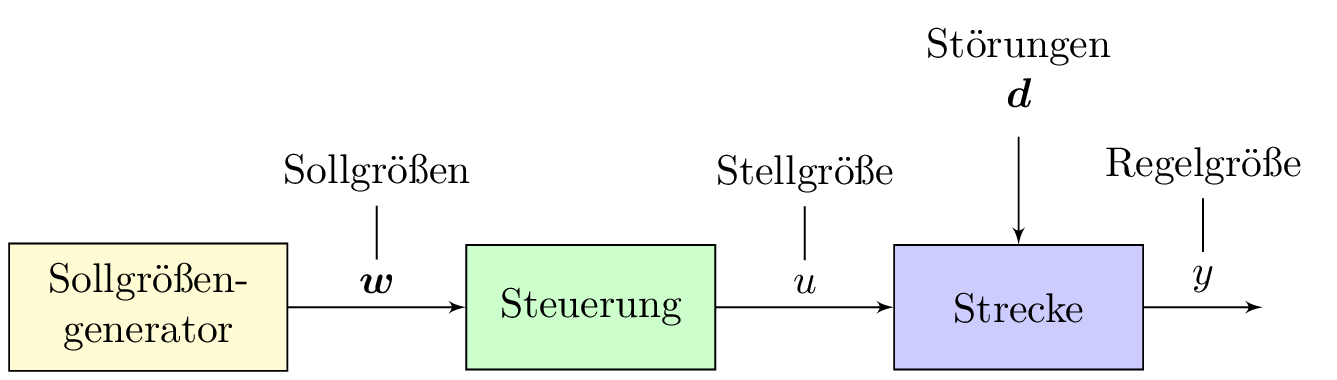

In [3]:
imag = Image("../../images/feedforward.png", width=600)
display(imag)

## System erster Ordnung

\begin{align*}
    \dot{y}(t) + a y(t) & = b u(t)
\end{align*}
mit Steuerung
\begin{align*}
    u_{\mathrm{r}}(t) & = \frac{1}{b}\left(\dot{y}_{\mathrm{r}}(t) + a y_{\mathrm{r}}(t) \right)
\end{align*}

__Definition Parameter__

In [4]:
tSim = np.linspace(0, 5, 1001)
x0 = [0]
t0 = 1

**Simulation**

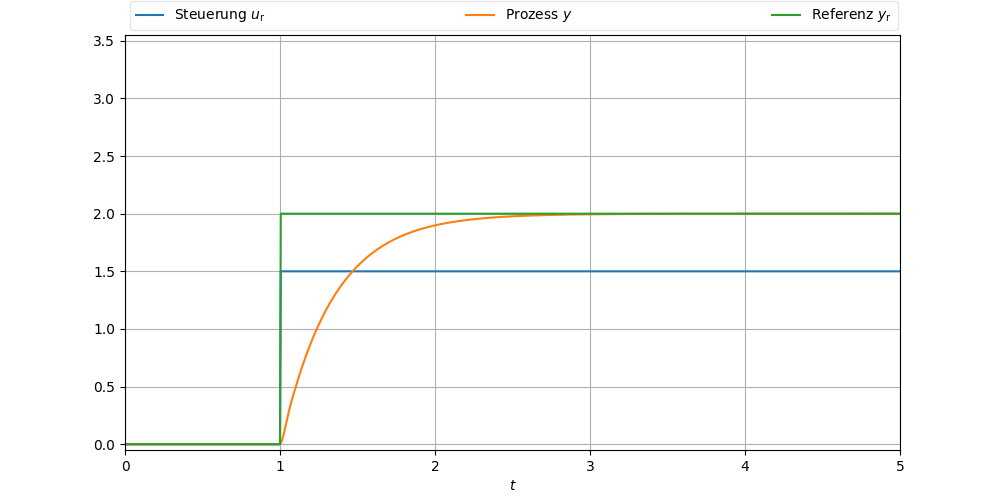

In [5]:
output = widgets.Output()

with output:
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(111)

plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.subplots_adjust(bottom=0.1, top=0.93, left=0.125, right=0.9)

ax.set_xlim([0, tSim[-1]]) 
ax.set_ylim([-0.05, 3.55]) 
ax.grid() 
ax.set_xlabel(r"$t$")

uSys, = ax.plot([], [], label=r'Steuerung $u_{\mathrm{r}}$')
ySys, = ax.plot([], [], label=r'Prozess $y$')
yRefSys, = ax.plot([], [], label=r'Referenz $y_{\mathrm{r}}$')

handlesAx, labelsAx = ax.get_legend_handles_labels()
fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.13, 0.94, 0.7675, .15), loc=3,
           ncol=3, mode="expand", borderaxespad=0., framealpha=0.5)

radioU = widgets.RadioButtons(options=['Sprung', 'Trajektorie'],
                              description='Eingang:',
                              disabled=False)
sliderDt = widgets.FloatSlider(value=3,
                               min=1,
                               max=4,
                               step=1,
                               description=r'$\Delta t$')
sliderYd = widgets.FloatSlider(value=2,
                              min=0.5,
                              max=2.5,
                              step=0.5,
                              description=r'$y_{\mathrm{d}}$')
sliderA = widgets.FloatSlider(value=3,
                              min=1,
                              max=4,
                              step=1,
                              description='a')
sliderB = widgets.FloatSlider(value=4,
                              min=3,
                              max=5,
                              step=1,
                              description='b')

def calcSystem(_):
    dt = sliderDt.value
    yd = sliderYd.value

    a = sliderA.value
    b = sliderB.value

    def prozess(t, x, u, a, b):
        dx = -a * x[0] + b * u(t)
        return dx
    
    if radioU.value == 'Sprung':
        yr = lambda t: yd if t > t0 else 0
        uTraj = lambda t: yd * a / b if t > t0 else 0
    else:
        yr = lambda t: yd * (3 * (t - t0) ** 2 / dt ** 2 - 2 * (t - t0) ** 3 / dt ** 3) if t0 <= t <= t0 + dt else 0 if t < t0 else yd 
        dyr = lambda t: yd * (6 * (t - t0) / dt ** 2 - 6 * (t - t0) ** 2 / dt ** 3) if t0 < t < t0 + dt else 0
        uTraj = lambda t: 1 / b * (dyr(t) + a * yr(t))
    
    res = solve_ivp(prozess,
                    [tSim[0], tSim[-1]],
                    x0,
                    t_eval=tSim, args=(uTraj, a, b))
    
    uSys.set_data(tSim, [uTraj(t) for t in tSim])
    ySys.set_data(tSim, res.y.T[:, 0])
    yRefSys.set_data(tSim, [yr(t) for t in tSim])
    fig.canvas.draw()

sliderA.observe(calcSystem, names='value')
sliderB.observe(calcSystem, names='value')

sliderDt.observe(calcSystem, names='value')
sliderYd.observe(calcSystem, names='value')
radioU.observe(calcSystem, names='value')

calcSystem(_)

ffControls = VBox([sliderYd, sliderDt])
ffControls.layout = make_box_layout()
sysControls = VBox([sliderA, sliderB])
sysControls.layout = make_box_layout()
inputControls = Box([radioU])
inputControls.layout = make_box_layout()

controls = HBox([sysControls, inputControls, ffControls])
VBox([controls, output], layout=Layout(display='flex', flex_flow='row', justify_content='center', align_items='center'))